In [1]:
# import the libraries

import torch, pdb # pdb is for debugging
from torch.utils.data import DataLoader # build iterable training data
from torch import nn # build deep learning architectures and models
from torchvision import transforms # allow us to transform our data in different ways
from torchvision.datasets import MNIST # dataset composed of images of numbers
from torchvision.utils import make_grid # to build a grid of images to evaluate during the training
from tqdm.auto import tqdm # for the bar showing the progress of the process
import matplotlib.pyplot as plt # plot image with all the visuals that we want

In [2]:
# we want to show a grid with a number of generated images vs. real images
# so we need some way to basically visualise this grid

# visualisation function
def show_tensor_images(image_tensor, ch=1, num_images=25, size=(28, 28)):
  # to detach image tensor from all the gradient computations and pass it to the cpu (we will use gpu for training)
  # tensor: 128 x 784(28x28)
  # put everyting into a new data
  data = image_tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  # create the grid
  grid = make_grid(data[:num_images], nrow=5).permute(1, 2, 0) # 1 x 28 x 28 --> permute : 28 x 28 x 1
  plt.imshow(grid)
  plt.show()

In [3]:
# setup of the main parameters

epochs = 500 # number of cycles in training
cur_step = 0 # each of step we process one batch
info_step = 300 # within an epoch, each step processes a batch
mean_gen_loss = 0 # mean generator loss
mean_disc_loss = 0 # mean discriminator loss

# some hyperparameters

z_dim = 64 # the dimensionality of the noise vector that is the input of the generator
lr = 0.00001 # learning rate
loss_func = nn.BCEWithLogitsLoss() # loss function, takes the logits and apply them all at once to a sigmoid function that is gonna set the range [0,1]

bs = 128 # batch size, how many images to be processed in the GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # selecting current device to do the processing

# dataloader is going to hold our training data
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()), # root folder, download it, transform data into multi-dimensional tensor
    batch_size = bs,
    shuffle = True) # every epoch reorder data

# number of steps = 60000 (MNIST size) / 128 = 468.75 almost 469

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


In [4]:
# declare our models

# generator
def genBlock(inp, out): # generator block with the size of input and the size of the output
  return nn.Sequential( # basically set a number of layers that are gonna be executed sequentially
      nn.Linear(inp, out), # a linear computation between input and output
      nn.BatchNorm1d(out), # 1D because we are using black & white and one dimemsioal images with a single channel, normalise the values that are coming from the previous layer
      nn.ReLU(inplace = True) # add non-linearity: in order to learn more complex functions
  )

class Generator(nn.Module):
  def __init__(self, z_dim = 64, i_dim = 784, h_dim = 128): # latent vector, output image size 28x28=784, base size of the hidden layer of the generator
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64 -> 128
        genBlock(h_dim, h_dim * 2), # 128 -> 256 we want to increase the size
        genBlock(h_dim * 2, h_dim * 4), # 256 -> 512 incresing the size
        genBlock(h_dim * 4, h_dim * 8), # 512 -> 1024
        nn.Linear(h_dim * 8, i_dim), # 1024 -> 784(28x28) we want to create an image with the same size of the MNIST images
        nn.Sigmoid() # set values [0,1]
    )

  def forward(self, noise): # the function that is gonna be executed when we basically run the instance of the class
    return self.gen(noise)

def gen_noise(number, z_dim): # the function that generates noise
  return torch.randn(number, z_dim).to(device) # returns a tensor field with random numbers from a normal dist. with mean of 0 and variance of 1 (standard normal distribution)

############################# ##########################

# discriminator
def discBlock(inp, out): # like generator
  return nn.Sequential(
    nn.Linear(inp, out),
    nn.LeakyReLU(0.2, inplace = True) # instead of giving 0 to negative values give them a small negative value on a slope
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim = 784, h_dim = 256):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim, h_dim * 4), # 784 -> 1024
        discBlock(h_dim * 4, h_dim * 2), # 1024 - > 512
        discBlock(h_dim * 2, h_dim), # 512 -> 256
        nn.Linear(h_dim, 1) # 256 -> 1
    )
  def forward(self, image): # takes the image
    return self.disc(image) # result of passing that image to the discriminator module


In [5]:
gen = Generator(z_dim).to(device) # declare the generator
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr) # declare the optimiser for the generator

disc = Discriminator().to(device) # declare the discriminator
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr) # declare the optimiser for the discriminator

In [6]:
gen # see what is inside in the Generator

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
disc # see what is inside in the Discriminator

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [8]:
x, y = next(iter(dataloader)) # iterator to get the next batch, dataloader will give the 128 images each iteration
print(x.shape) # 128 x 1 x 28 x 28
print(y.shape) # 128
print(y[:10]) #print first 10 values in the images

torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor([8, 1, 3, 0, 9, 6, 1, 3, 2, 6])


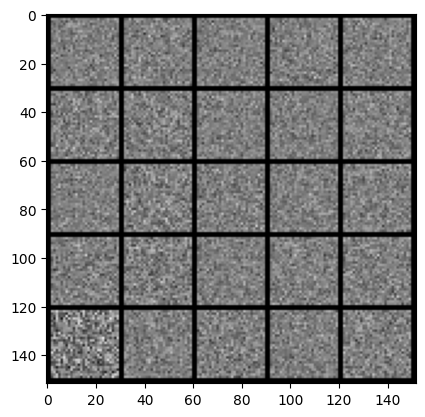

In [9]:
noise = gen_noise(bs, z_dim) # batch size: 128, z_dim: 64
fake = gen(noise) # pass the noise to the Generator
show_tensor_images(fake) # show the fake image
# this is the initial output of passing the noise through the generator.
# because the generator did not begin to learn, it produces a very noisy output.

In [10]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim) # get set of noise vectors
  fake = gen(noise) # pass these vectors to generator
  pred = disc(fake) # pass the output of the generator to the discriminator
  targets = torch.ones_like(pred) # create a tensor wit the dimensionality of predictions, fill it with ones, that's the generator's goal actuall
  gen_loss = loss_func(pred, targets) # compare the predictions and target values to fool the discriminator
  return gen_loss

# discriminator loss
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim) # get set of noise vectors
  fake = gen(noise) # pass these vectors to generator
  disc_fake = disc(fake.detach()) # when pytorch backpropogates, the loss of the discriminator, we don't want to change the parameters of the generator when optimising the discriminator (detach)
  disc_fake_targets = torch.zeros_like(disc_fake) # zeros: fake
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets) # compare the output of the dicriminator with the fake targets

  disc_real = disc(real) # pass the real images to the discriminator
  disc_real_targets = torch.ones_like(disc_real) # ones: real
  disc_real_loss = loss_func(disc_real, disc_real_targets) # compare the output of the dicriminator with the real targets

  disc_loss = (disc_fake_loss + disc_real_loss) / 2 # average the two losses
  return disc_loss

In [11]:
# training loop

# 60000 MNIST images / 128 size of each batch = 468.75 = 469 steps in each epoch
# each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader): # for the information that is returned at each point by the dataloader, wrapped by tqdm (a good bar visualisation)
    # discriminator
    disc_opt.zero_grad() # take the discriminator optimiser and set its gradients to zero

    cur_bs = len(real) # current batch size at each step real:128 x 1 x 28 x 28 (except the last step)
    real = real.view(cur_bs, -1) # 128 x 784 reshape the real images into the size of current batch size
    real = real.to(device) # put the real images on the device

    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim) # calculate the discriminator loss

    disc_loss.backward(retain_graph = True) # backpropagate the loss to calculate all the gradients
    disc_opt.step() # update the discriminator parameters

############################# ##########################
    # generator
    gen_opt.zero_grad() # take the generator optimiser and set its gradients to zero

    gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim) # calculate the generator loss
    gen_loss.backward(retain_graph = True) # backpropagate the loss to calculate all the gradients
    gen_opt.step()

    # visualisation & stats
    mean_disc_loss += disc_loss.item() / info_step # mean discriminator loss
    mean_gen_loss += gen_loss.item() / info_step # mean generator loss

    # we want to show the information
    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim) # get noise vectors
      fake = gen(fake_noise) # pass these vectors to generator
      show_tensor_images(fake) # show the fake image
      show_tensor_images(real) # show the real image
      print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_gen_loss}, discriminator loss: {mean_disc_loss}") # print everything
      mean_gen_loss = 0 # reset the mean generator loss
      mean_disc_loss = 0 # reset the mean discriminator loss
    cur_step += 1 # increment the steps

Output hidden; open in https://colab.research.google.com to view.